In [4]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 머신러닝
from sklearn import datasets, metrics

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 타이타닉호의 생존자 예측
- 반응변수가 범주형
    - 이진(0,1) 분류 모델
- 기존의 선형회귀에서 사용했던 평가 방법을 그대로 사용할 수 없다. 
    - Accuracy, Confusion matrix, Precision, Recall, F1-Score

In [5]:
rawData = pd.read_csv('./data/titanic_train.csv')

## 전처리 
- 데이터를 모델링에 적합한 형태로 변환
- 설명력이 높은 변수를 찾는 것!
    - Feature Extraction
    - Featrue Selection 

### 결측치
- 채우거나, 제거

In [6]:
rawData.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


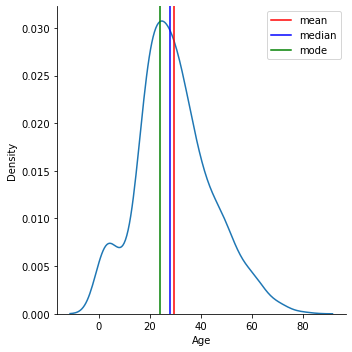

In [8]:
from scipy.stats import mode
sns.displot(rawData, x='Age', kind='kde')
plt.axvline(rawData['Age'].mean(), label='mean', color='red')
plt.axvline(rawData['Age'].median(), label='median', color='blue')
plt.axvline(mode(rawData['Age'])[0], label='mode', color='green')
plt.legend()
plt.show()

In [9]:
# 나이의 평균값으로 결측치를 대체
rawData['Age'].fillna(rawData['Age'].mean(), inplace=True)

In [10]:
rawData['Age'].isna().sum()

0

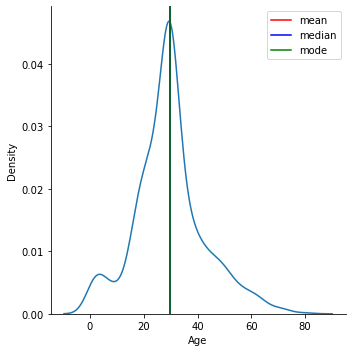

In [11]:
sns.displot(rawData, x='Age', kind='kde')
plt.axvline(rawData['Age'].mean(), label='mean', color='red')
plt.axvline(rawData['Age'].median(), label='median', color='blue')
plt.axvline(mode(rawData['Age'])[0], label='mode', color='green')
plt.legend()
plt.show()

In [12]:
# Embarked에 대해서는 결측치가 있는 데이터는 제거
rawData.dropna(subset=['Embarked'], inplace=True)

In [13]:
rawData['Embarked'].isna().sum()

0

### 범주형 변수에 대한 전처리
- 더미 변수(dummy variable)

In [14]:
rawData.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [15]:
dummy_columns = ['Pclass', 'Sex', 'Embarked']

for col in dummy_columns:
    df = pd.get_dummies(rawData[col], prefix=col)
    rawData = pd.concat([rawData, df], axis=1)

### 연속형 변수에 대한 전처리

#### Age 변수는 구간별로 나눠서 더비변수로 변환

In [16]:
rawData['Age'].max()

80.0

In [17]:
labels = ['kids', 'teenager', '20s', '30s', '40s', '50s', 'senior']
bins = [0, 10, 20, 30, 40, 50, 60, 80]
df = pd.get_dummies(pd.cut(rawData['Age'], bins=bins, labels=labels))
rawData = pd.concat([rawData, df], axis=1)

#### scaling 

In [18]:
scale_columns = ['SibSp', 'Parch', 'Fare']

scaler = StandardScaler()
rawData[scale_columns] = scaler.fit_transform(rawData[scale_columns])

#### inverse scaling

In [19]:
scaler.inverse_transform(rawData[scale_columns])

array([[ 1.    ,  0.    ,  7.25  ],
       [ 1.    ,  0.    , 71.2833],
       [ 0.    ,  0.    ,  7.925 ],
       ...,
       [ 1.    ,  2.    , 23.45  ],
       [ 0.    ,  0.    , 30.    ],
       [ 0.    ,  0.    ,  7.75  ]])

## 마무리

In [20]:
rawData.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'kids', 'teenager', '20s', '30s', '40s', '50s', 'senior'],
      dtype='object')

In [21]:
drop_columns = [ 'PassengerId', 'Pclass', 'Name', 'Sex', 'Age',  'Ticket', 'Cabin', 'Embarked']
rawData.drop(columns=drop_columns, inplace=True)

In [22]:
rawData.head()

,Survived,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,kids,teenager,20s,30s,40s,50s,senior
0,0,0.431350,-0.474326,-0.500240,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0
1,1,0.431350,-0.474326,0.788947,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0
2,1,-0.475199,-0.474326,-0.486650,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0
3,1,0.431350,-0.474326,0.422861,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0
4,0,-0.475199,-0.474326,-0.484133,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0


### 훈련셋과 테스트셋을 분리

In [45]:
target = rawData['Survived']
features = rawData.drop(columns=['Survived'])

x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(711, 18) (178, 18) (711,) (178,)


# 분류모형의 평가방법

| - | Y_true(0) | Y_true(1) |
|:---:|:---:|:---:|
| Y_predict(0) | TP <br> 실제: 0 <br> 예측: 0 | FP <br> 실제: 1 <br> 예측: 0 |
| Y_predict(1) | FN <br> 실제: 0 <br> 예측: 1 | TN <br> 실제: 1 <br> 예측: 1 |

---

1. Accuracy
$$
    \frac{TP + TN}{TP + TN + FP + FN}
$$
- 전체 데이터에서 TP와 TN의 비율
- 데이터의 불균형이 심한 경우에는 정확한 지표로 삼기 어렵다.   
- TP의 갯수가 압도적으로 많은 경우 TN의 오분류가 많아도 반영이 안된다. 

---

2. precision(정밀도)
$$
    \frac{TP}{TP + FP}
$$
- 0으로 예측한 데이터 중에 실제 0이었던 데이터의 비율

---

3. recall(재현율)

$$
    \frac{TP}{TP + FN}
$$
- 실제 0이었던 데이터 중에 0으로 예측한 비율

---

4. F-1 score
$$
    f1 = 2 \cdot \frac{precision \cdot recall}{precision\; + \;recall}
$$



# 로지스틱 회귀모형
- 일반화 선형회귀모형
- 분류 모형에서 주로 많이 사용(반드시 분류 모형에서만 사용되는건 아니다)
- logit 함수를 이용해서 0과 1사이의 확률값으로 변경
    - 분류모형이지만 선형회귀와 같은 방법으로 적용이 가능

In [24]:
model = LogisticRegression(penalty='none').fit(x_train, y_train)

## 회귀계수 확인

In [25]:
coef = pd.DataFrame(model.coef_.T, columns=['coef'])
columns = pd.DataFrame(x_train.columns, columns=['name'])
pd.concat([coef, columns], axis=1)

,coef,name
0,-0.429994,SibSp
1,-0.129964,Parch
2,0.202262,Fare
3,0.886016,Pclass_1
4,0.174147,Pclass_2
5,-1.021935,Pclass_3
6,1.362928,Sex_female
7,-1.324700,Sex_male
8,0.335063,Embarked_C
9,-0.004806,Embarked_Q


## 학습정확도

In [26]:
model.predict_proba(x_train)

array([[0.96648044, 0.03351956],
       [0.5537265 , 0.4462735 ],
       [0.86775695, 0.13224305],
       ...,
       [0.09819266, 0.90180734],
       [0.14868186, 0.85131814],
       [0.92221751, 0.07778249]])

In [27]:
yhat_train = model.predict(x_train)

In [28]:
cmat = confusion_matrix(yhat_train, y_train)

In [29]:
acc = (cmat[0,0] + cmat[1,1]) / np.sum(cmat)
acc

0.8059071729957806

In [30]:
precision = cmat[0,0] / (cmat[0,0] + cmat[0,1])
precision

0.8351648351648352

In [31]:
recall = cmat[0,0] / (cmat[0,0] + cmat[1,0])
recall

0.8577878103837472

In [32]:
f1 = f1_score(y_train, yhat_train)
f1

0.7366412213740459

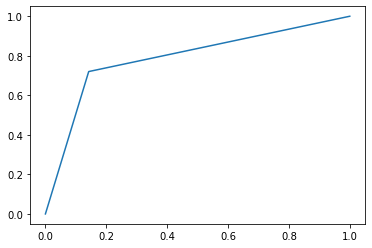

In [33]:
fpr, tpr, _ = roc_curve(y_train, yhat_train)
plt.plot(fpr, tpr)
plt.show()

In [34]:
auc = roc_auc_score(y_train, yhat_train)
auc

0.7889685320575452

## 테스트 정확도
- 모델의 예측력을 확인 
- Accuracy, F1, Auc

In [35]:
yhat_test = model.predict(x_test)

In [36]:
confusion_matrix(yhat_test, y_test)

array([[96, 24],
       [10, 48]])

In [37]:
acc = accuracy_score(y_test, yhat_test)
acc

0.8089887640449438

In [38]:
f1 = f1_score(y_test, yhat_test)
f1

0.7384615384615385

In [39]:
auc = roc_auc_score(y_test, yhat_test)
auc

0.7861635220125786

# SVC 모형

## SVC 파라미터 추정

In [50]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

sets = [x for x in range(1, 1000)]
scores = []

for c in sets:
    svc = svm.SVC(kernel='rbf', C=c, gamma='scale').fit(x_train, y_train)
    score = cross_val_score(svc, x_test, y_test, cv=10, scoring='accuracy') 
    scores.append(score.mean())

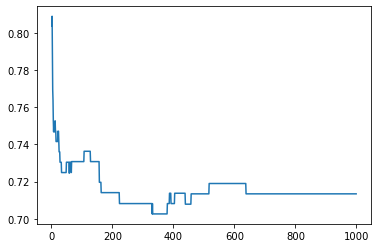

In [51]:
plt.plot(sets, scores)
plt.show()

In [52]:
np.argmax(scores)

1

## SVC 모형 적합

In [53]:
model = svm.SVC(kernel='rbf', C=1, gamma='scale').fit(x_train, y_train)

## 모형 평가

In [54]:
yhat_test = model.predict(x_test)

In [55]:
confusion_matrix(yhat_test, y_test)

array([[101,  22],
       [  5,  50]])

In [56]:
acc = accuracy_score(y_test, yhat_test)
acc

0.848314606741573

In [57]:
f1 = f1_score(y_test, yhat_test)
f1

0.7874015748031497

In [58]:
auc = roc_auc_score(y_test, yhat_test)
auc

0.8236373165618448

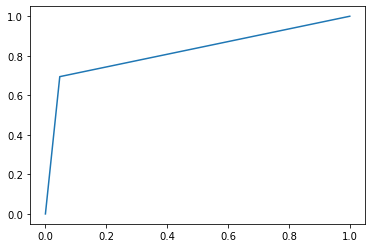

In [59]:
fpr, tpr, _ = roc_curve(y_test, yhat_test)
plt.plot(fpr, tpr)
plt.show()

# KNN Classifier 모형

In [74]:
from sklearn import neighbors
sets = [x for x in range(1, 100)]
scores = []

for k in sets:
    model = neighbors.KNeighborsClassifier(n_neighbors=k).fit(x_train, y_train)
    score = cross_val_score(model, x_test, y_test, cv=10, scoring='accuracy') 
    scores.append(score.mean())

In [75]:
np.argmax(scores)

10

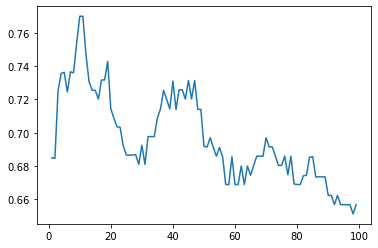

In [76]:
plt.plot(sets, scores)
plt.show()

In [84]:
model = neighbors.KNeighborsClassifier(n_neighbors=10).fit(x_train, y_train)

In [85]:
yhat_test = model.predict(x_test)

In [86]:
confusion_matrix(yhat_test, y_test)

array([[98, 27],
       [ 8, 45]])

In [87]:
acc = accuracy_score(y_test, yhat_test)
acc

0.8033707865168539

In [88]:
f1 = f1_score(y_test, yhat_test)
f1

0.72

In [89]:
auc = roc_auc_score(y_test, yhat_test)
auc

0.7747641509433962

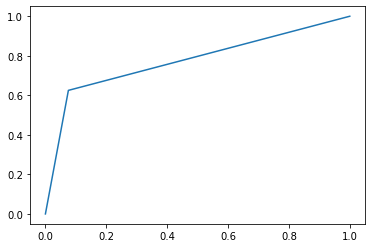

In [90]:
fpr, tpr, _ = roc_curve(y_test, yhat_test)
plt.plot(fpr, tpr)
plt.show()

# Decision Tree Classification

In [91]:
from sklearn import tree
sets = [x for x in range(1, 100)]
scores = []

for k in sets:
    model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=k).fit(x_train, y_train)
    score = cross_val_score(model, x_test, y_test, cv=10, scoring='accuracy') 
    scores.append(score.mean())

In [93]:
np.argmax(scores)

2

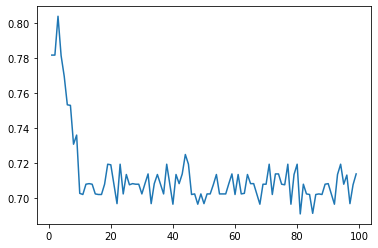

In [94]:
plt.plot(sets, scores)
plt.show()

In [95]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=2).fit(x_train, y_train)

In [96]:
yhat_test = model.predict(x_test)

In [97]:
confusion_matrix(yhat_test, y_test)

array([[104,  41],
       [  2,  31]])

In [98]:
acc = accuracy_score(y_test, yhat_test)
acc

0.7584269662921348

In [99]:
f1 = f1_score(y_test, yhat_test)
f1

0.5904761904761905

In [100]:
auc = roc_auc_score(y_test, yhat_test)
auc

0.7058438155136268

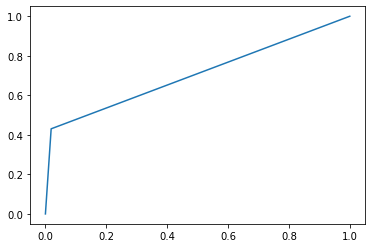

In [101]:
fpr, tpr, _ = roc_curve(y_test, yhat_test)
plt.plot(fpr, tpr)
plt.show()

# Random Forest Classifier

In [104]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators= 500, 
    random_state=123
).fit(x_train, y_train)

In [105]:
yhat_test = model.predict(x_test)

In [106]:
confusion_matrix(yhat_test, y_test)

array([[91, 17],
       [15, 55]])

In [107]:
acc = accuracy_score(y_test, yhat_test)
acc

0.8202247191011236

In [108]:
f1 = f1_score(y_test, yhat_test)
f1

0.7746478873239437

In [109]:
auc = roc_auc_score(y_test, yhat_test)
auc

0.8111897274633123

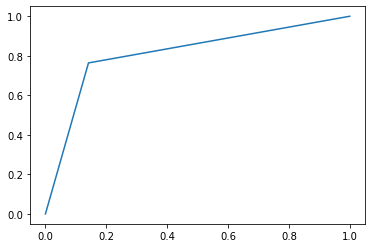

In [110]:
fpr, tpr, _ = roc_curve(y_test, yhat_test)
plt.plot(fpr, tpr)
plt.show()